 # Import Dataset

In [1]:
import pandas as pd
import numpy as np

from cmdstanpy import CmdStanModel
import arviz as az

import matplotlib.pyplot as plt

In [2]:
with open("FeconditaFinale.csv", "rb") as f:
    dataset=pd.read_csv(f)
    
dataset = dataset.sort_values(by=['Territorio', 'TIME']) # the proximity matrix is built with the prov in alphabetic order

0.015125712353150588
1.3187169811320756
(106, 10)


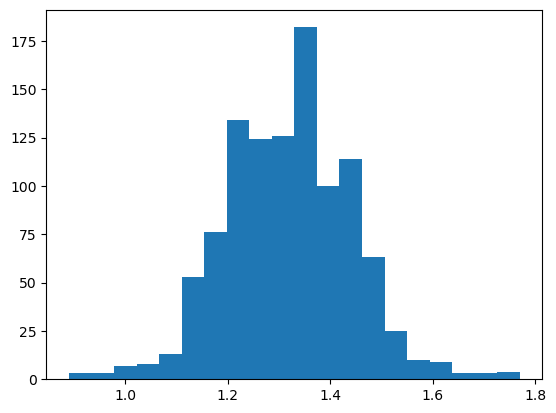

In [3]:
Y=np.array(dataset["tasso.di.fecondità.totale"])

print(np.var(Y))
print(np.mean(Y))


y = []
y_tmp = np.zeros(10)
for prov in np.unique(dataset["Territorio"]):
    data_prov = dataset[dataset["Territorio"] == prov]
    y_tmp = np.array(data_prov["tasso.di.fecondità.totale"])
    y.append(y_tmp)
y = np.array(y)
# print(y)
print(y.shape)
plt.hist(Y,bins=20)    
plt.show()

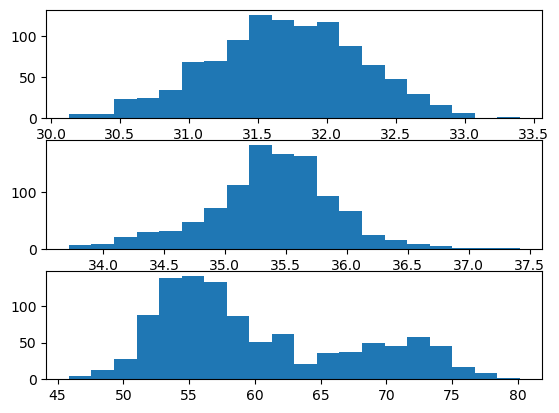

In [4]:
# mega matrix with the covariates, da normalizzare forse?
X1 = np.array(dataset["età.media.delle.madri.al.parto"])
X2 = np.array(dataset["età.media.dei.padri.alla.nascita.del.figlio"])
X3 = np.array(dataset["tasso.di.inattività.delle.femmine"])
X4 = np.array(dataset["tasso.di.inattività.dei.maschi"])
# X5 = np.array(dataset["tasso.di.occupazione.delle.femmine"])
# X6 = np.array(dataset["tasso.di.occupazione.dei.maschi"])
# da valutare se vanno standardizzate
fig, axs = plt.subplots(3)
axs[0].hist(X1,bins=20)
axs[1].hist(X2,bins=20)
axs[2].hist(X3,bins=20)
plt.show()

In [5]:
#Standardization on X
X1 = (X1-np.mean(X1))/np.sqrt(np.var(X1))
X2 = (X2-np.mean(X2))/np.sqrt(np.var(X2))
X3 = (X3-np.mean(X3))/np.sqrt(np.var(X3))
X4 = (X4-np.mean(X4))/np.sqrt(np.var(X4))
# X5 = (X5-np.mean(X5))/np.sqrt(np.var(X5))
# X6 = (X6-np.mean(X6))/np.sqrt(np.var(X6))

#Standardization on Y
y= (y-np.mean(y))/np.sqrt(np.var(y))

In [6]:
P = 4
X=np.ones((1060,P+1))
X[:,1]=X1
X[:,2]=X2
X[:,3]=X3
X[:,4]=X4
# X[:,5]=X5
# X[:,6]=X6
X_r = np.reshape(X,(106,10,P+1))
# print(X_r)
X_r.shape

[[[ 1.         -1.38733389 -1.10026324  2.05144371  0.30656436]
  [ 1.         -1.77061906 -1.54219572  1.89211824  0.5393075 ]
  [ 1.         -1.11355877 -1.13869215  1.78561354  1.09128765]
  ...
  [ 1.         -0.18272337 -0.23561273  1.69594042  0.33345848]
  [ 1.         -0.29223342 -0.04346817  1.66432349  0.72523738]
  [ 1.         -0.03670997 -0.38932838  1.78846129  1.48582068]]

 [[ 1.         -1.64285734 -1.02340541 -0.34660173  0.24677987]
  [ 1.         -1.27782385 -0.73518858 -0.71508174 -0.21575525]
  [ 1.         -0.73027361 -0.37011392 -0.41062779  0.02698863]
  ...
  [ 1.         -0.20097504  0.26396312 -0.48714728 -0.31928696]
  [ 1.          0.03629673  0.74432451 -0.3382982  -0.29482666]
  [ 1.          0.10930342  0.49453658 -0.19435256  0.16948911]]

 [[ 1.         -0.82153198 -0.31247055 -0.82850129  0.08918214]
  [ 1.         -0.60251189 -0.23561273 -0.80411705 -0.75917724]
  [ 1.         -0.43824681  0.03338965 -0.94808962 -0.59204811]
  ...
  [ 1.          1.

(106, 10, 5)

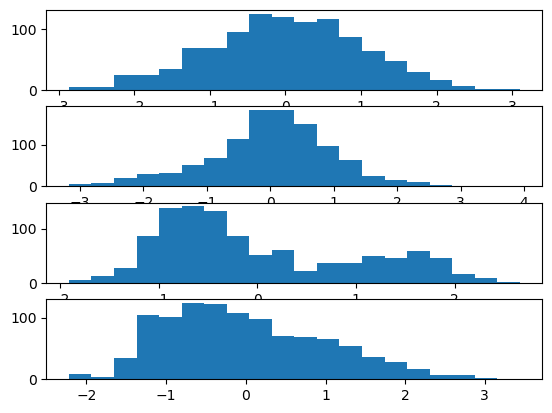

In [7]:
fig, axs = plt.subplots(P)
axs[0].hist(X1,bins=20)
axs[1].hist(X2,bins=20)
axs[2].hist(X3,bins=20)
axs[3].hist(X4,bins=20)
# axs[4].hist(X5,bins=20)
# axs[5].hist(X6,bins=20)
plt.show()

In [8]:
I = 106
T = 4
H = 10

new_X = np.zeros((I,T,P+1))
new_Y = np.zeros((I,T))

for i in range(I):
    for t in range(T):
        new_X[i,t,:] = X_r[i,(10//T)*t,:]
        new_Y[i,t]   = y[i,(10//T)*t]

X_r = new_X
y = new_Y

In [9]:
with open("Proximity_matrix_finale.csv", "rb") as f:
    W_raw=pd.read_csv(f)

In [10]:
W_raw=np.matrix(W_raw)
W_raw

matrix([[1, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 1]])

# Prepare data for model

In [11]:
for i in range(106):
    W_raw[i,i] = 0

W_raw=np.matrix(W_raw)
Wt = W_raw.transpose()
(Wt == W_raw).all()

True

In [12]:
# compute Qinv
one_vector = np.ones(shape = (I,1))
B = np.matmul(W_raw , one_vector)  
A =  np.diagflat(np.array(B))
W_intermedia = A - W_raw


rho = 0.95 
Q = rho * W_intermedia  + (1-rho) * np.eye(I)
Qinv = np.linalg.inv(Q)
# Qinv.shape
W_intermedia.shape

(106, 106)

In [13]:
#Qinv must be positive definite
for i in range(I):
    for j in range(I):
        Qinv[j,i] = Qinv[i,j]

Qinv=np.matrix(Qinv)
Qinvt = Qinv.transpose()
print((Qinv == Qinvt).all())

#np.linalg.eig(Qinv)

True


# Prior predictive check 

0.4495815


(array([  3.,   1.,   4.,   7.,   6.,  13.,  23.,  68.,  60., 112.,  87.,
        134., 105., 128.,  78.,  93.,  55.,  44.,  14.,   6.,   8.,   3.,
          1.,   4.,   3.]),
 array([-3.48588269, -3.19967273, -2.91346276, -2.6272528 , -2.34104284,
        -2.05483288, -1.76862292, -1.48241296, -1.196203  , -0.90999304,
        -0.62378307, -0.33757311, -0.05136315,  0.23484681,  0.52105677,
         0.80726673,  1.09347669,  1.37968666,  1.66589662,  1.95210658,
         2.23831654,  2.5245265 ,  2.81073646,  3.09694642,  3.38315638,
         3.66936635]),
 <BarContainer object of 25 artists>)

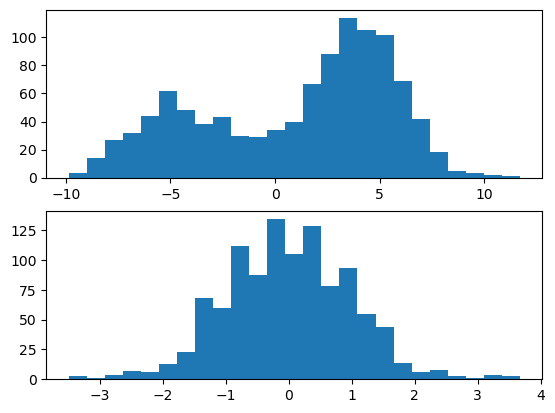

In [49]:
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions
np.random.seed()

# weight construction
weight = np.zeros(H)
alpha=np.random.gamma(a_alpha,b_alpha)
v = np.zeros(H)
v[0] = np.random.beta(a = 1,b = alpha)
weight[0] = v[0]
for h in range(1,H-1):
    v[h] = np.random.beta(a = 1,b = alpha)
    cumprod = np.cumprod(1 - v[0:h])[h-1]
    weight[h] = v[h]*cumprod
    
weight = weight/ np.sum(weight)
# to be chekcked

# betas construction 
betas = []
beta = np.zeros(P+1)
for h in range(H):
    beta = np.array(np.random.multivariate_normal(mean=mu_0, cov = sigma_0*np.eye(P+1)))
    betas.append(beta)
                                         
betas = np.array(betas)
                                         
# tau2
tau2 = tfd.InverseGamma(concentration = a_tau2 , scale = b_tau2).sample()
print(tau2)

xi=np.random.beta(a=a_xi,b=b_xi)
# random effects construction 
W=np.zeros((I,T))
diag_matrix_xis= xi*np.eye(I) #diag(xis)                                          
W[:,0]=np.random.multivariate_normal(mean=np.zeros(I),cov=tau2*Qinv)
for t in range(T-1):
    W[:,t+1]=np.random.multivariate_normal(mean=np.matmul(diag_matrix_xis,W[:,t]), cov=tau2*Qinv)                                        
                    
# sigma
sigma2 = tfd.InverseGamma(concentration = a_sigma2 , scale = b_sigma2).sample()                                     

# y construction 
y_p = np.zeros((I*T))                                   
for i in range(I):                                   
    for h in range(H):
        y_p[i*T:(i+1)*T] += weight[h]*np.random.multivariate_normal(mean=np.matmul(X_r[i],betas[h]) + W[i,:], cov = sigma2*np.eye(T))
fig, axs = plt.subplots(2)                                         
axs[0].hist(y_p,bins=25)
axs[1].hist(y.reshape(I*T),bins=25)   # lo voglio simile all'istogramma sopra 



In [15]:
mu_0 = 0*np.ones(P+1) #as in the paper
mu_w_1 = np.zeros(I) #as in the paper
sigma_0 = 9 #covariance matrix
a_alpha = 3
b_alpha = 7
a_tau2 = 3
b_tau2 = 2
a_sigma2 = 3
b_sigma2 = 2
rho = 0.95
a_xi = 1
b_xi = 1

data = {
    "I": I,
    "T": T,
    "P": P,
    "H": H,
    "y": y,
    "X": X_r,
    "mu_0": mu_0,
    "sigma_0": sigma_0,
    "mu_w_1": mu_w_1,
    "a_alpha": a_alpha,
    "b_alpha": b_alpha,
    "a_tau2": a_tau2,
    "b_tau2": b_tau2,
    "a_sigma2": a_sigma2,
    "b_sigma2": b_sigma2,
    "rho": rho,
    "a_xi": a_xi,
    "b_xi": b_xi,
    "inv_Q": Qinv
}

# Model

In [16]:
dp_mix_stan = """
data
{
    int I; // number of areal locations
    int T; // number of time steps
    int P; // number of covariates
    int H; // truncation of stick breaking construction dp
    
    array[I] vector[T] y; // value of interest
    array[I] matrix[T,P+1] X; // covariates matrices for each province
      
    // hyperpar vector of regressors
    vector[P+1] mu_0; 
    real        sigma_0;
    
    // mean of w_1 (random effect for every province at time 1)
    vector[I] mu_w_1;
    
    // alpha
    real a_alpha;
    real b_alpha;
    
    // tau^2
    real a_tau2;
    real b_tau2;
    
    // sigma^2
    real a_sigma2;
    real b_sigma2;
    
    // rho 
    real rho;
    
    //xis
    real a_xi;
    real b_xi;

    // Qinv
    matrix[I,I] inv_Q;
}

transformed data {
    matrix[I, I] L;
    L = cholesky_decompose(inv_Q);
}

parameters
{
    real<lower=0> alpha;
    real<lower=0> sigma2; 
    real<lower=0> tau2;  
    
    // autoregressive coefficient construction
    real<lower=0,upper=1> xi_constructor;
    
    // betas for the mixture of the dirichlet process
    array[H] vector[P+1] betas; 

    // for the construction of the dirichlet process
    vector<lower=0,upper=1>[H-1] vs;
    
    // for the random effect construction 
    array[T] vector[I] w_raw;
}

transformed parameters
{   
    // weights stick breaking construction
    simplex[H] omegas; 
    
    // sbc stuff
    vector[H-1] cumprod_one_mv;    
    cumprod_one_mv = exp(cumulative_sum(log1m(vs)));
    
    omegas[1] = vs[1];
    omegas[2:(H-1)] = vs[2:(H-1)] .* cumprod_one_mv[1:(H-2)];
    omegas[H] = cumprod_one_mv[H-1];
    
    // autoregressive coefficient of the random effects
    real xi = 2*xi_constructor-1;
    
    // random effects tmp
    matrix[I,T]                ws_tmp;
    
    ws_tmp[1:I,1] =  mu_w_1 + L*w_raw[1];
    
    for (t in 2:T)
        ws_tmp[1:I,t] = ws_tmp[1:I,t-1]*xi + L*w_raw[t]; 
    
    matrix[T,I]   ws = (ws_tmp)'; //otherwise I have to transpose in the for loop at each iteration
    
    // Stan wants std
    real sigma = sqrt(sigma2);
    real tau = sqrt(tau2);
}

model
{
    alpha  ~ gamma(a_alpha,b_alpha);
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    vs     ~ beta(1,alpha); 
    xi_constructor ~ beta(a_xi,b_xi);
    
    w_raw[1] ~ normal(0, tau); 
    
    for (t in 2:T)
        w_raw[t] ~ normal(0, tau);
    
    for (h in 1:H)
        betas[h] ~ normal(mu_0, sigma_0);
    
    vector[H] log_probs;
    
    for (i in 1:I) {
        
        for (h in 1:H) 
    
            log_probs[h] = log(omegas[h]) + normal_lpdf(y[i] | X[i]*betas[h] + ws[1:T,i], sigma);
        
        target += log_sum_exp(log_probs);
    }
}

generated quantities 
{   
    // vector of cluster allocations
    vector[I] s;
    
    // log likelihood for each areal location 
    vector[I] log_lik;
    
    array[I] vector[H] log_probs;
    
    for (i in 1:I) 
    {
        for (h in 1:H) 
            log_probs[i,h] = log(omegas[h]) + normal_lpdf(y[i] | X[i]*betas[h] + ws[1:T,i], sigma);
        
        s[i] = categorical_rng(softmax(log_probs[i]));
        log_lik[i] = log_sum_exp(log_probs[i]);
    }
    
        
}
"""
stan_file = "True_Dataset.stan"

with open(stan_file, "w") as fp:
    fp.write(dp_mix_stan)
    
dp_mix = CmdStanModel(stan_file=stan_file)

09:43:13 - cmdstanpy - INFO - compiling stan file /home/daan/bayesian-project/True_Dataset.stan to exe file /home/daan/bayesian-project/True_Dataset
09:43:33 - cmdstanpy - INFO - compiled model executable: /home/daan/bayesian-project/True_Dataset


In [ ]:
fit = dp_mix.sample(data
                    , seed = [14,245,1515,784]
                    , iter_warmup = 5000
                    , iter_sampling = 5000
#                    , adapt_init_phase = 1500
#                    , adapt_metric_window = 1500
#                    , adapt_step_size = 1500
#                    , show_console = True
#                    , chains=4
                   , adapt_delta=0.9
#                    , step_size = 0.2
                   , max_treedepth = 100
                   )

09:49:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [91]:
fit.diagnose() # bello schifo :(

KeyboardInterrupt: 

In [22]:
fit_az = az.from_cmdstanpy(fit)

# Model Saving

In [23]:
s = (fit.s).astype(int)

np.savetxt("true_dataset_posterior_s.csv", s, delimiter=",")
s.shape

(40000, 106)

In [31]:
np.savetxt("true_dataset_posterior_betas.csv", fit.betas, delimiter=",")
fit.betas.shape

ValueError: Expected 1D or 2D array, got 3D array instead

In [102]:
np.savetxt("true_dataset_posterior_xi.csv", fit.xi, delimiter=",")
np.savetxt("true_dataset_posterior_alpha.csv", fit.alpha, delimiter=",")

In [ ]:
#Clustering on Stan

# Posterior inference

/home/daan/.local/lib/python3.10/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (70), generating only 20 plots
  warnings.warn(


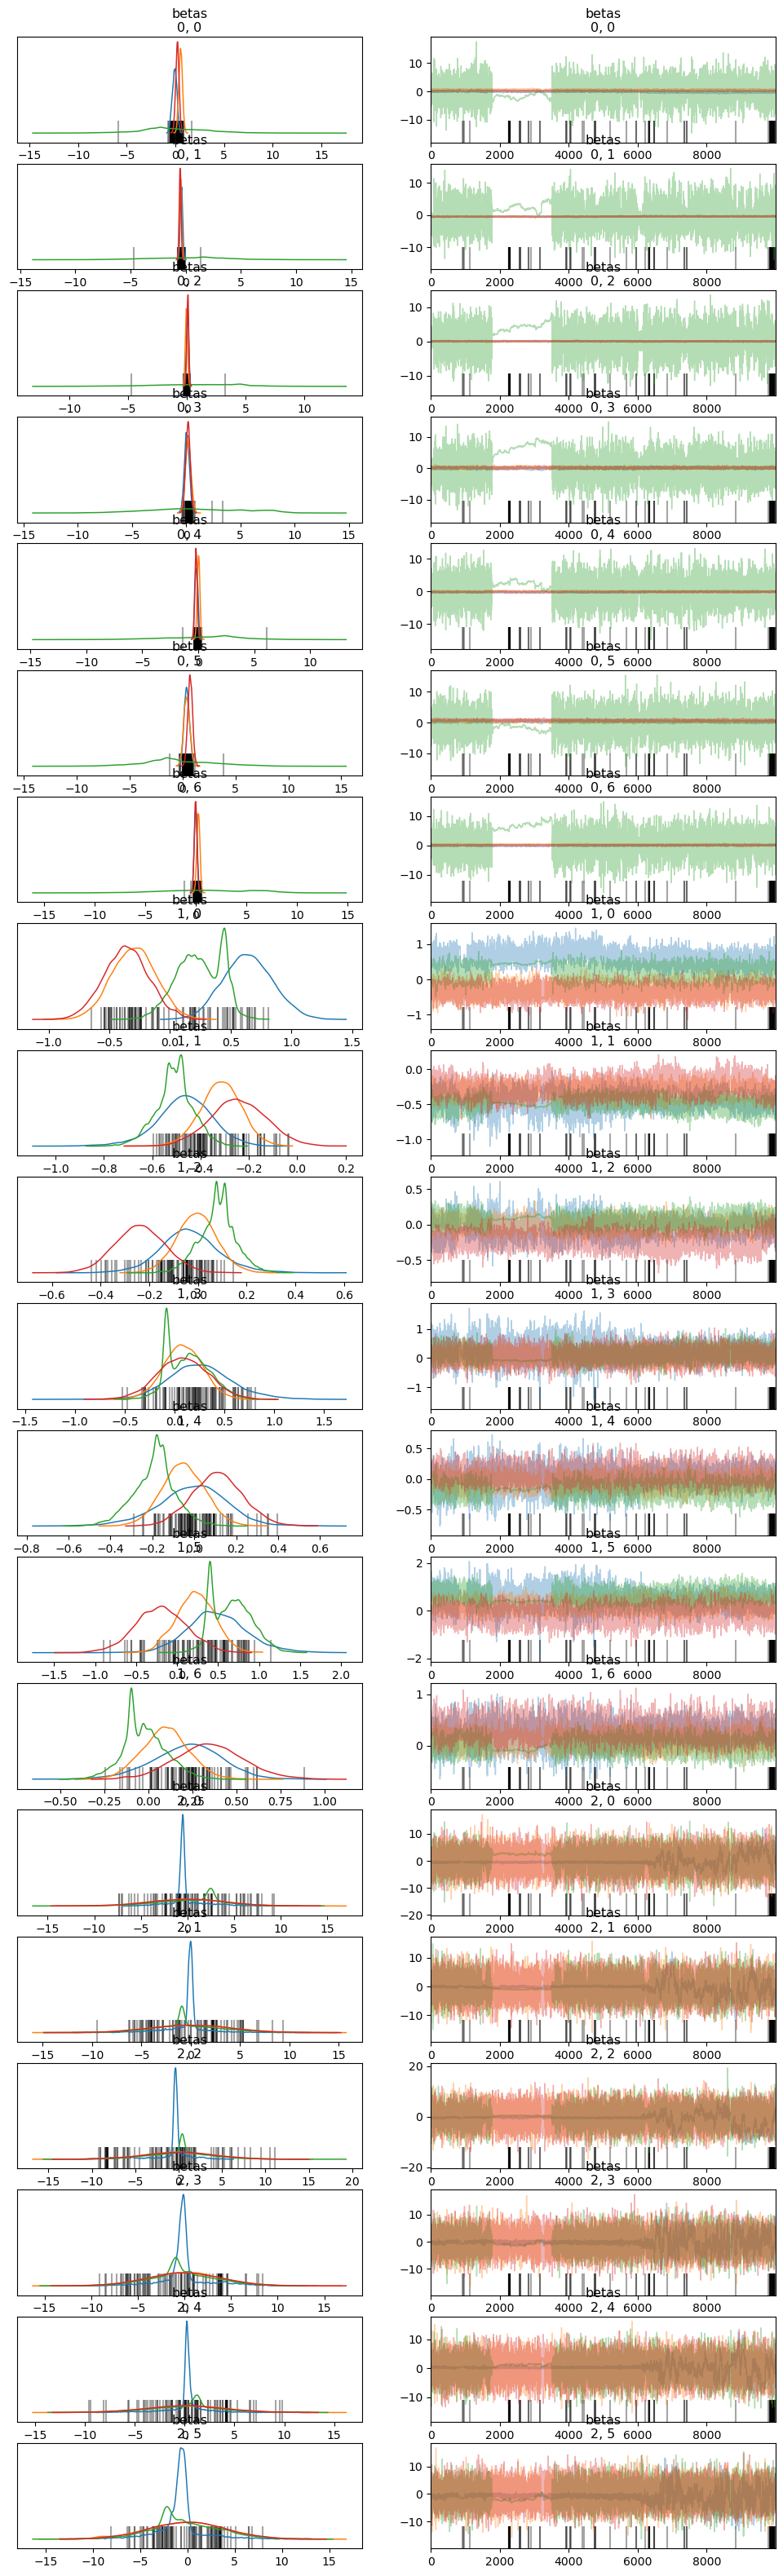

In [24]:
az.plot_trace(fit_az,var_names=["betas"], compact = False)
plt.show()

In [94]:
print(fit_az.posterior.s.values[0,999,:]) #niente clustersss :(

[5. 5. 3. 3. 3. 3. 3. 2. 5. 5. 3. 2. 5. 3. 2. 5. 3. 5. 3. 5. 2. 5. 3. 3.
 3. 3. 3. 2. 3. 2. 5. 3. 5. 2. 3. 3. 5. 5. 3. 3. 3. 3. 2. 5. 2. 5. 3. 3.
 3. 2. 5. 5. 3. 2. 2. 2. 2. 3. 2. 5. 2. 2. 3. 5. 3. 2. 2. 3. 3. 3. 3. 3.
 3. 7. 2. 3. 3. 5. 2. 3. 3. 2. 5. 5. 2. 3. 3. 3. 3. 5. 3. 5. 3. 3. 2. 5.
 5. 3. 2. 3. 5. 5. 2. 5. 3. 5.]


# Todo List

In [ ]:
# Salso package for clustering
# media dei beta, ci dovrebbe volere un attimo 
# media dei random effects, ci dovrebbe valere un attimo
# qualche posterior prediticve check training set/test set
# validazione modello e diagnostica mcmc, voglio che posso fidarmi di mcmc

# Credible interval, WAIC, LOO

In [101]:
# posterior credible interval per i beta ma se li vuoi anche per i random effects
hdis = az.hdi(fit, var_names=["betas"]).betas.values
hdis

array([[[-1.44178 ,  3.68595 ],
        [-1.70259 ,  2.25224 ],
        [-2.50776 ,  3.11602 ],
        [-1.9835  ,  2.9824  ]],

       [[-0.183672,  0.899811],
        [-0.597575, -0.296632],
        [-0.150025,  1.13025 ],
        [-0.621193,  0.804849]],

       [[-5.16481 ,  5.23143 ],
        [-6.1871  ,  2.92609 ],
        [-5.53262 ,  5.14442 ],
        [-4.76858 ,  5.95304 ]],

       [[-6.26068 ,  6.66336 ],
        [-6.44101 ,  6.47135 ],
        [-6.67673 ,  6.3329  ],
        [-6.40344 ,  6.68719 ]],

       [[-6.52365 ,  7.14191 ],
        [-6.17958 ,  6.99112 ],
        [-6.89589 ,  7.2596  ],
        [-7.65166 ,  7.59238 ]],

       [[-6.86577 ,  7.85127 ],
        [-7.1075  ,  7.59297 ],
        [-7.31082 ,  7.29344 ],
        [-7.54968 ,  7.09659 ]],

       [[-7.2799  ,  7.52079 ],
        [-7.45486 ,  7.32272 ],
        [-7.96524 ,  7.42548 ],
        [-7.33244 ,  7.87836 ]],

       [[-7.45736 ,  7.5548  ],
        [-7.56727 ,  7.59799 ],
        [-7.88135 ,  7.603

In [108]:
# computation of WAIC 
az.waic(fit)

/home/daan/.local/lib/python3.10/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 12000 posterior samples and 106 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -191.51    15.34
p_waic      175.15        -

There has been a warning during the calculation. Please check the results.

In [25]:
#computation of LOO
az.loo(fit)

/home/daan/.local/lib/python3.10/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/daan/.local/lib/python3.10/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/daan/.local/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 40000 posterior samples and 106 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -237.40    17.53
p_loo      220.13        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)         10    9.4%
   (0.7, 1]   (bad)        80   75.5%
   (1, Inf)   (very bad)   16   15.1%

# Binder Loss su R

In [39]:
# The ones below are my (Anna) dierectories, do not run or run with your directories

import os

os.environ['R_HOME'] = '/home/daan'
os.environ['R_USER'] = '/home/daan/anaconda3/envs/bayesian/lib/python3.10/site-packages/rpy2' #path depends on where you installed Python


In [40]:
import rpy2.robjects as robjects


Failed to import the API mode with "libffi.so.7: cannot open shared object file: No such file or directory" and unable to import the ABI mode.


ImportError: libffi.so.7: cannot open shared object file: No such file or directory

In [332]:
r = robjects.r
out= r.source('True_dataset_binder_loss.R')

R[write to console]: Caricamento del pacchetto richiesto: salso



In [ ]:
with open("true_dataset_s_binder.csv", "rb") as f:
    s_binder=pd.read_csv(f)
s_fixed= np.array(s_binder['V1'])
s_fixed

# Model with fixed clustering using Binder Loss

In [ ]:
# Fixed clustering s to study betas depending on clusters
beta_clus_stan = """
data
{
    int<lower=1> I; // number of areal locations
    int<lower=1> T; // number of time steps
    int<lower=1> P; // number of covariates
    int<lower=1> H; // number of possible clusters
    
    array[I] vector[T] y; // value of interest
    array[I] matrix[T,P+1] X; // covariates matrices for each province
    
      
    // hyperpar vector of regressors
    vector[P+1]     mu_0; 
    real        sigma_0;
    
    // w_1
    vector[I] mu_w_1;
    
    // alpha
    real<lower=0> a_alpha;
    real<lower=0> b_alpha;
    
    // tau^2
    real<lower=0> a_tau2;
    real<lower=0> b_tau2;
    
    // sigma^2
    real<lower=0> a_sigma2;
    real<lower=0> b_sigma2;
    
    // rho 
    real rho;
    
    //xis
    real<lower=0> a_xi;
    real<lower=0> b_xi;
    
    int s[I];
    
    // Qinv
    matrix[I,I] inv_Q;
}

transformed data
{
    matrix[I, I] L;
    L = cholesky_decompose(inv_Q);
}

parameters
{
    real<lower=0> sigma2;
    real<lower=0> tau2;
    
    // autoregressive coefficient construction
    real<lower=0,upper=1> xi_constructor;
    
    // betas for the mixture of the dirichlet process
    array[H] vector[P+1] betas_clus; 
    
    // for the random effect construction 
    array[T] vector[I] w_raw;
}

transformed parameters
{   
    // autoregressive coefficient of the random effects
    real xi = 2*xi_constructor-1;
    
    // random effects tmp
    matrix[I,T]                ws_tmp;
    
    ws_tmp[1:I,1] =  mu_w_1 + L*w_raw[1];
    
    for (t in 2:T)
        ws_tmp[1:I,t] = ws_tmp[1:I,t-1]*xi + L*w_raw[t]; 
    
    matrix[T,I]   ws = (ws_tmp)'; //otherwise I have to transpose in the for loop at each iteration
    
    // Stan wants std
    real sigma = sqrt(sigma2);
    real tau = sqrt(tau2);
}

model
{
    
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    xi_constructor ~ beta(a_xi,b_xi);
    
    w_raw[1] ~ normal(0, tau); 
    
    for (t in 2:T)
        w_raw[t] ~ normal(0, tau);
    
    for (h in 1:H)
        betas_clus[h] ~ normal(mu_0, sigma_0);
    
    for (i in 1:I){
        int clus_i = s[i]+1;
        
        y[i] ~ normal(X[i]*betas_clus[clus_i] + ws[1:T,i], sigma);
    }    
}

"""

stan_file = "beta_clus.stan"

with open(stan_file, "w") as fp:
    fp.write(beta_clus_stan)
    
beta_clus = CmdStanModel(stan_file=stan_file)

08:03:10 - cmdstanpy - INFO - compiling stan file C:\Users\Anna\Documents\GitHub\bayesian-project\beta_clus.stan to exe file C:\Users\Anna\Documents\GitHub\bayesian-project\beta_clus.exe


In [ ]:
s= s_fixed.astype(int)

data_clus = {
    "I": I,
    "T": T,
    "P": P,
    "H": H,
    "y": y,
    "X": X_r,
    "mu_0": mu_0,
    "Sigma_0": Sigma_0,
    "mu_w_1": mu_w_1,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "rho": 0.95,
    "a_xi": 1,
    "b_xi": 1,
    "s":s
    "inv_Q": Qinv
}


In [ ]:
fit_clus = beta_clus.sample(data_clus
#                     , show_console = True
#                    , chains=4
#                     , adapt_delta=0.9
#                    , step_size = 1.5
#                    , max_treedepth = 100
                   )